# **Task: Predict Fraud transaction.**

# **I won't be publishing the dataset, so in this pipeline I'll just explain the logic of my approach to solving the fraud problem.**

# Brief dataset overview

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
data = pd.read_csv('dataset.csv')

Firstly, I looked at the data using `data.info()` and `data.head()` to understand what I would be dealing with.

---




The dataset consists of 150,000 entries - these are customer bank data, 25 columns with **fraud** already marked as `false` or `true`.

A little more than half of the data is categorical data, and mainly it is located in columns of type `object`, the smaller half is numerical data of type `float64`.

In [ ]:
data.info()

Then by using `data.describe()` and `data.describe(include='O')` we display general information about numerical and categorical data. We will return to numerical data later when we talk about outliers, but for now we will focus on categorical ones.

In [ ]:
data.describe()

In [ ]:
data.describe(include='O')

When reviewing the categorical data, I found out that the address and merchant ID columns all had unique values.

You can say: "Stop, but ***some addresses or certain merchant can really be associated with fraud!***". Yes, so after learning that a certain merchant is a fraud we can, for example, to blacklist him and use this info further.

But now for us this means that they do not have much value, so we will get rid of them.

In [ ]:
data.head()

# Clean data

We've reviewed our data, so now it would be nice to know a few more things.
First of all, we visualize the distribution of fraud.

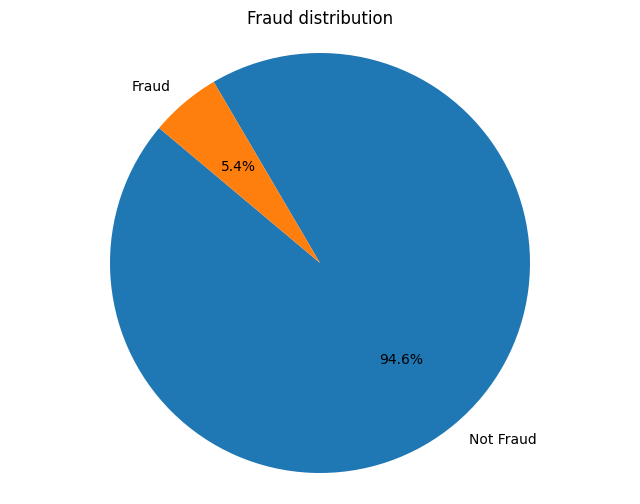

In [ ]:
data['fraud'] = data['fraud'].astype(int)
paysim_1=data.copy()

plt.figure(figsize=(8, 6))
plt.pie(paysim_1['fraud'].value_counts(), labels=['Not Fraud', 'Fraud'], autopct='%1.1f%%', startangle=140)
plt.title('Fraud distribution')
plt.axis('equal')
plt.show()

As you can see on the graph, we have an unbalanced dataset, because fraud was recorded in only 5.5% of the sample. This may affect the ability of the classification model to correctly identify the underrepresented class.

What can be done about it?
- Use of class weights
- Use of resampling
- Use of ensemble methods such as Gradient Boosting

**Let's try to balance** at the stage of model creation **by setting the weight of classes** (spoiler, I will still use Gradient Boosting).

And also at the model evaluation stage, it will be worth paying attention to the ***recall*** and*** F1-score*** accuracy metrics.



In [ ]:
data.isnull().sum()

Here I use `data.isnull().sum()` to figure out **how many values were missed**.

~100 values for each of the columns is not much for us, so we can delete it. We also delete columns that contained too many unique values.

In [ ]:
data = data.drop(columns=columns_to_del)

In [ ]:
data = data.dropna(subset=columns)

Before filling in the missing numerical values, we visualize their distribution using a boxplot. We are also interested in whether they have outliers.

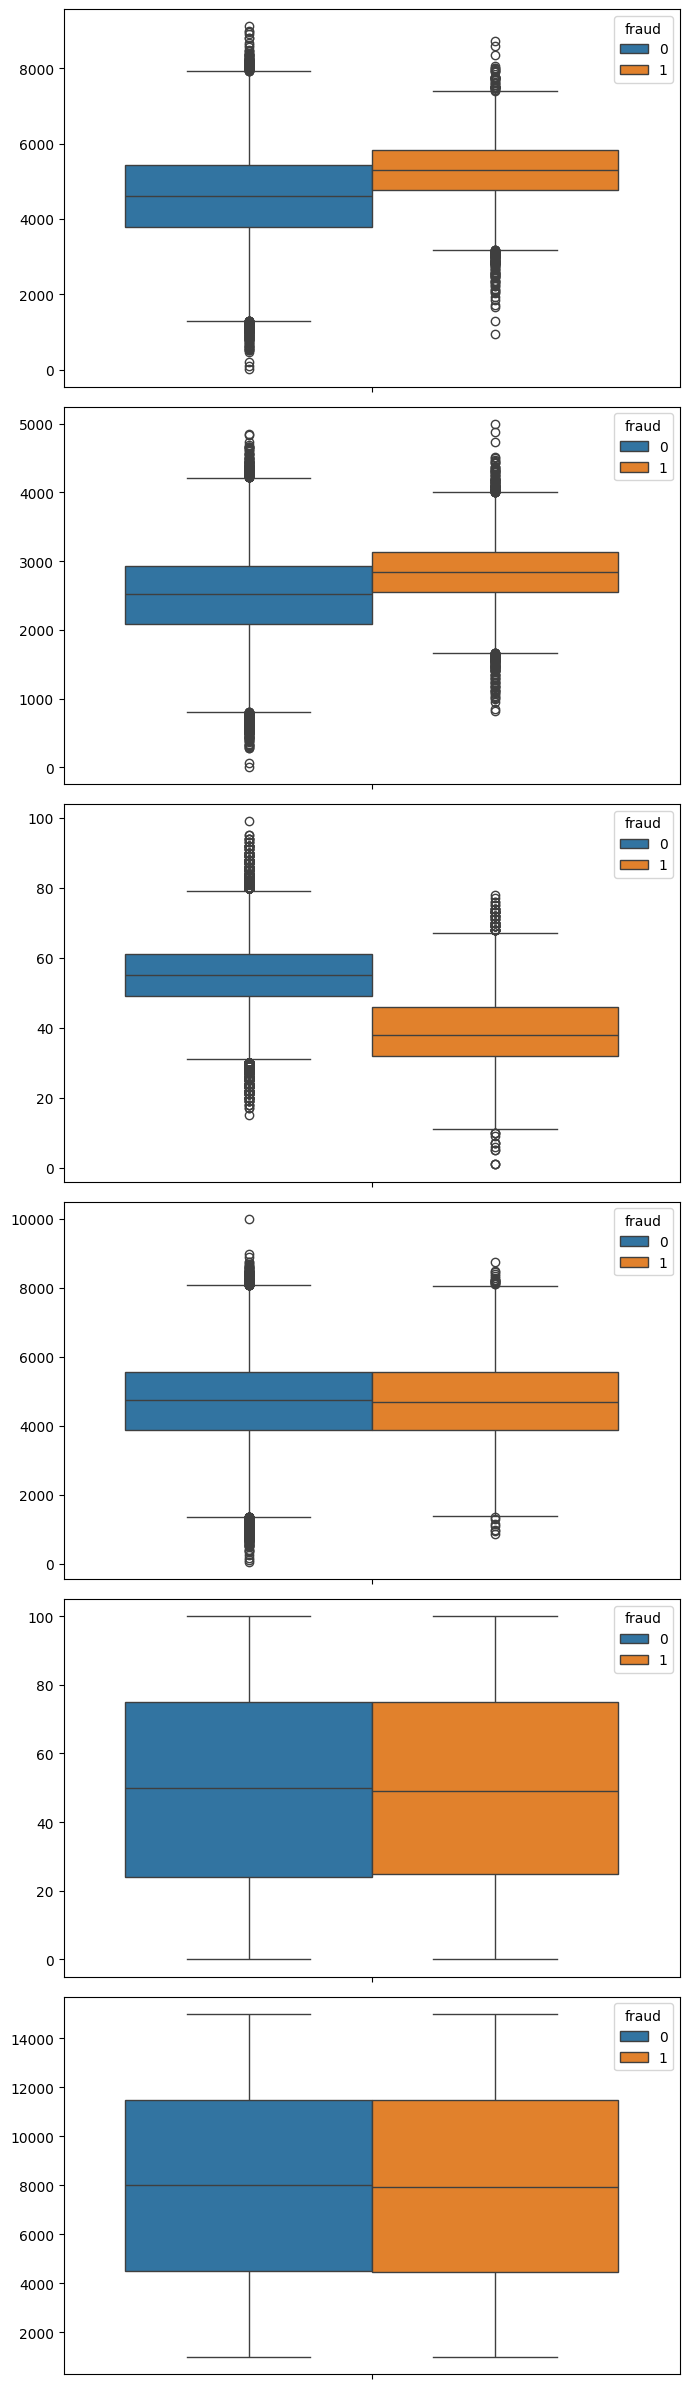

In [ ]:
data = data.dropna(subset=columns)
rows = len(columns)
cols = 1
fig, axes = plt.subplots(rows, cols, figsize=(7, 4*rows))

for i, col in enumerate(columns):
    sns.boxplot(data=data, y=col, hue='fraud', ax=axes[i]) #ящик з вусами
    axes[i].set_ylabel('') # delete names of columns

    #sns.violinplot(data=data, y=col, hue='fraud', ax=axes[i], split='true')
    #axes[i].set_title(col)

plt.tight_layout()
plt.show()

Well, we can see that some boxplots have outliers. But I have something to explain to you.

In these columns, these ***outliers are not abnormal*** - for example, the payment amount can be very small or very large. If it is not less than and not equal to 0, it is ok.

These outliers can show us interesting patterns, for example, too large an payment amount or a large number of small payments can mean that it is a fraud.

In [ ]:
for column in columns_to_fill:
    value = np.random.uniform(data[column].mean() - data[column].std(), data[column].mean() + data[column].std())
    data[column].fillna(value, inplace=True)

In [ ]:
!pip install pyyaml ua-parser user-agents

***user agents*** column has a very large number of unique values, let's break it down into main categories, among which there may be dependencies: browser, OS and device.

In [ ]:
from user_agents import parse

def parse_user_agent(user_agent):
    ua = parse(user_agent)
    return ua.browser.family, ua.browser.version, ua.os.family, ua.os.version, ua.device.family, ua.device.brand

data[['browser', 'browser_version', 'os', 'os_version', 'device', 'device_brand']] = data['user_agent'].apply(lambda x: pd.Series(parse_user_agent(x)))


***date*** will also be divided into several categories: day of the week and period of the day.

In [ ]:
data['date'] = pd.to_datetime(data['date'])
data['day_of_week'] = data['date'].dt.dayofweek

# (0 - 5:59 - ранок, 6 - 11:59 - день, 12 - 17:59 - вечір, 18 - 23:59 - ніч)
data['day_period'] = pd.cut(data['date'].dt.hour, bins=[-1, 5, 11, 17, 24], labels=[0, 1, 2, 3], right=True)

data.drop(columns=['date'], inplace=True)


In [ ]:
data['year'] = data['event_timestamp'].dt.year  # decided to add more year and month columns (later it turned out that the correlations here are too small)
data['month'] = data['event_timestamp'].dt.month

In [ ]:
data.drop(columns=[ 'device_brand', 'user_agent'], inplace=True) # it turned out that there are >70k Nan values in device_brand

In [ ]:
data['day_period'] = data['day_period'].astype('int64')

# Encoding

So, I fixed missing data and added new columns that can help find certain dependencies. But since we have categorical variables, it is necessary to encode them.

I applied ***Label Encoding*** to columns where we have few unique values, and ***Frequency Encoding*** - where we have many unique values and where it is important for us to know the importance of categories based on their frequency.

In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

data['os_version'] = data['os_version'].astype(str)

# Label Encoding
data['some_columns'] = label_encoder.fit_transform(data['some_columns'])
data['some_columns'] = label_encoder.fit_transform(data['some_columns'])
#...
data['some_columns'] = label_encoder.fit_transform(data['some_columns'])
data['some_columns'] = label_encoder.fit_transform(data['some_columns'])

In [ ]:
# Frequency Encoding
browser_combined_freq = data['browser_combined'].value_counts(normalize=True).to_dict()
#repeat for all target columns
data['browser_combined_encoded'] = data['browser_combined'].map(browser_combined_freq)

In [ ]:
data.drop(columns=col, axis=1, inplace=True)

# Data Analysis

> **Let's try to answer the question "What distinguishes a fraudster from an ordinary user"**



Consider the correlation matrix.

PS. Although correlations were found, they are rather weak. The first few columns that are displayed in the matrix will play a major role in detecting ***fraud***.

In [ ]:
fraud = data['fraud']
data.drop('fraud', axis=1, inplace=True)
data['fraud'] = fraud

correlation_matrix = data.corr()
mask = np.zeros_like(correlation_matrix)

plt.figure(figsize=(30,15))
sns.heatmap(correlation_matrix, annot=True, annot_kws={"size":14})
sns.set_style('white')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

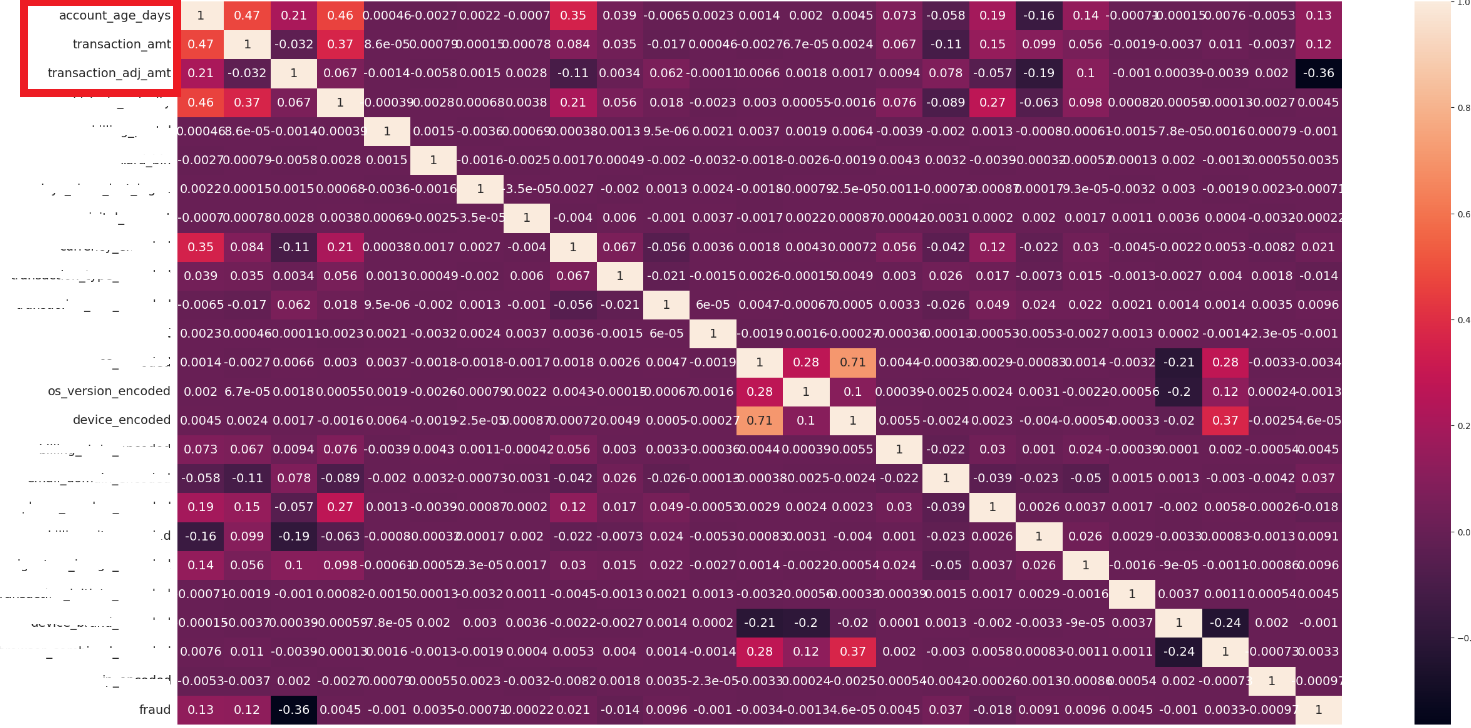

In [ ]:
data.to_csv('cleaned.csv', index=False)

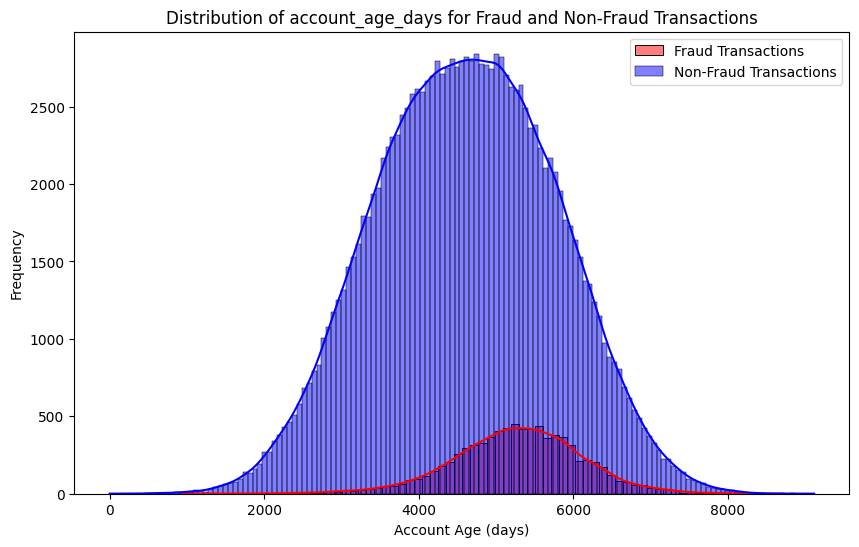

In [ ]:
fraud_transactions = data[data['fraud'] == 1]
non_fraud_transactions = data[data['fraud'] == 0]

plt.figure(figsize=(10, 6))
sns.histplot(data=fraud_transactions, x='account_age_days', color='red', label='Fraud Transactions', kde=True)
sns.histplot(data=non_fraud_transactions, x='account_age_days', color='blue', label='Non-Fraud Transactions', kde=True)
plt.title('Distribution of account_age_days for Fraud and Non-Fraud Transactions')
plt.xlabel('Account Age (days)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

Let's try to understand how a fraudster thinks.

Most accounts of fraudsters match the majority.
Also, we will try to display ***the transaction amount and the change in the amount***. As you can see, fraudsters do not change the amounts too much.

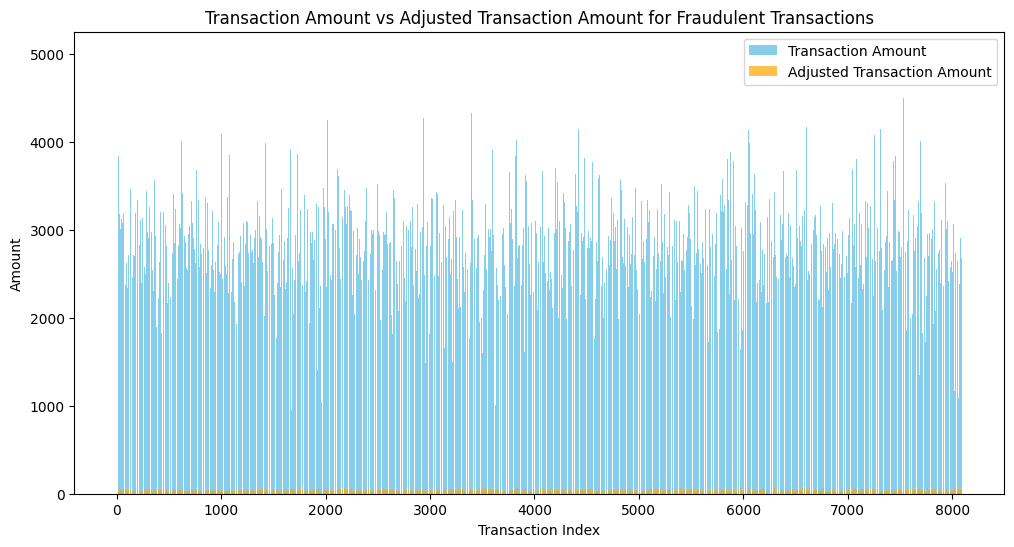

In [ ]:
fraud_transactions = data[data['fraud'] == 1]

plt.figure(figsize=(12, 6))
plt.bar(range(len(fraud_transactions)), fraud_transactions['amt'], label='Transaction Amount', color='skyblue')
plt.bar(range(len(fraud_transactions)), fraud_transactions['adj'], label='Adjusted Transaction Amount', color='orange', alpha=0.7)
plt.xlabel('Transaction Index')
plt.ylabel('Amount')
plt.title('Transaction Amount vs Adjusted Transaction Amount for Fraudulent Transactions')
plt.legend()
plt.show()


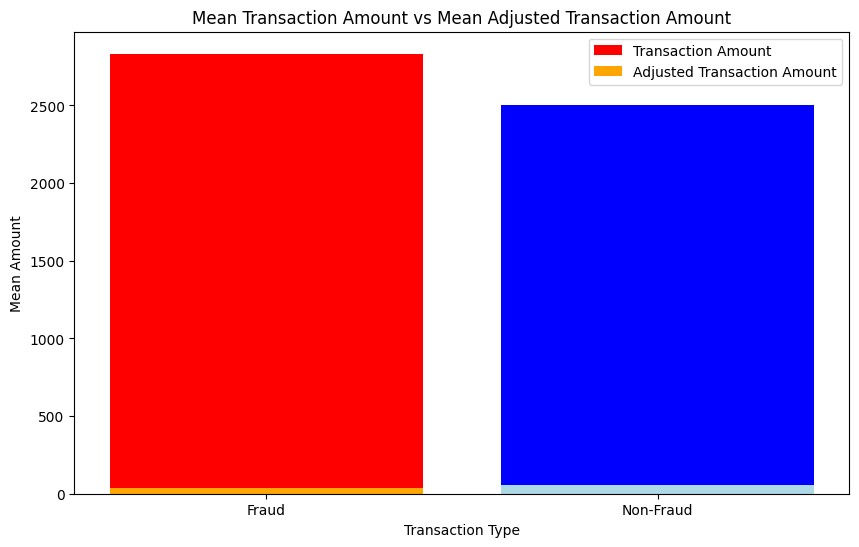

In [ ]:
fraud_transactions = data[data['fraud'] == 1]
non_fraud_transactions = data[data['fraud'] == 0]

fraud_mean_transaction_amt = fraud_transactions['amt'].mean()
fraud_mean_transaction_adj_amt = fraud_transactions['adj'].mean()

non_fraud_mean_transaction_amt = non_fraud_transactions['amt'].mean()
non_fraud_mean_transaction_adj_amt = non_fraud_transactions['adj'].mean()

plt.figure(figsize=(10, 6))
plt.bar(['Fraud', 'Non-Fraud'], [fraud_mean_transaction_amt, non_fraud_mean_transaction_amt], color=['red', 'blue'], label='Transaction Amount')
plt.bar(['Fraud', 'Non-Fraud'], [fraud_mean_transaction_adj_amt, non_fraud_mean_transaction_adj_amt], color=['orange', 'lightblue'], label='Adjusted Transaction Amount')
plt.xlabel('Transaction Type')
plt.ylabel('Mean Amount')
plt.title('Mean Transaction Amount vs Mean Adjusted Transaction Amount')
plt.legend()
plt.show()

But by depicting **the average amounts and the change in the amount for fraudulent and non-fraudulent transactions**, you can see that this is generally normal for ordinary users as well. Although ***for fraudulent transactions the average amount may be slightly higher***.

You can say, "It's all because the data is generated" - yes, but in real life, it's also hard to distinguish a fraudster from an ordinary person, as they do everything to make the system perceive them as normal.

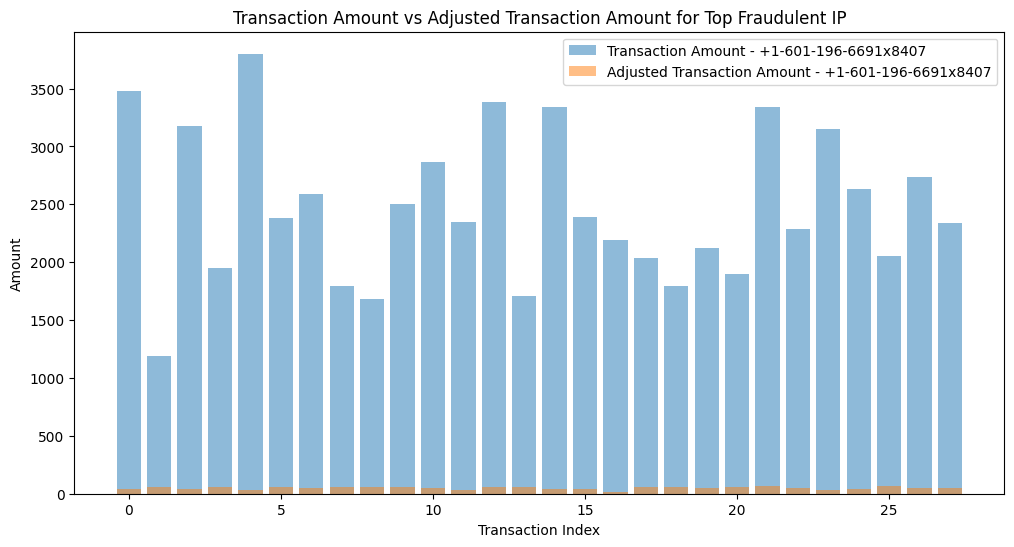

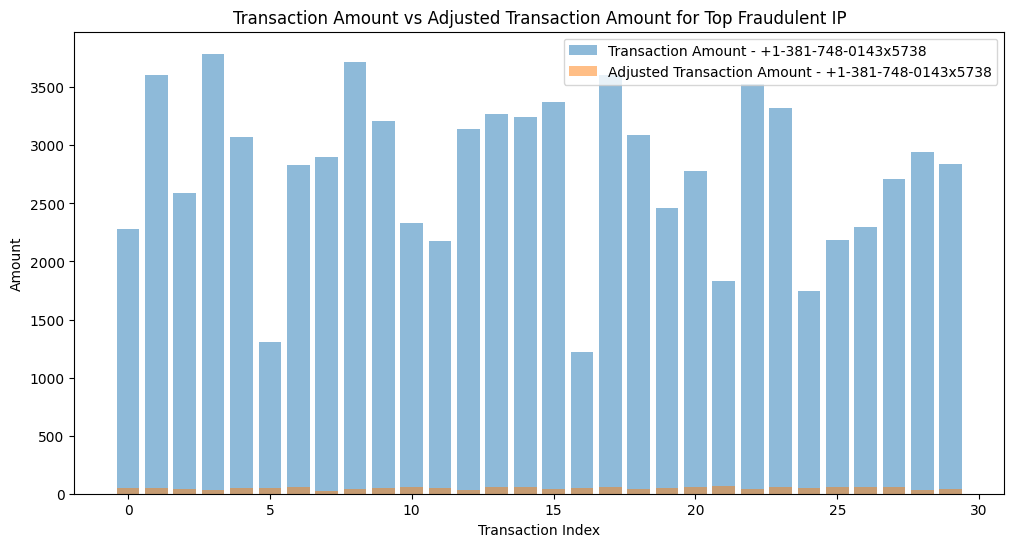

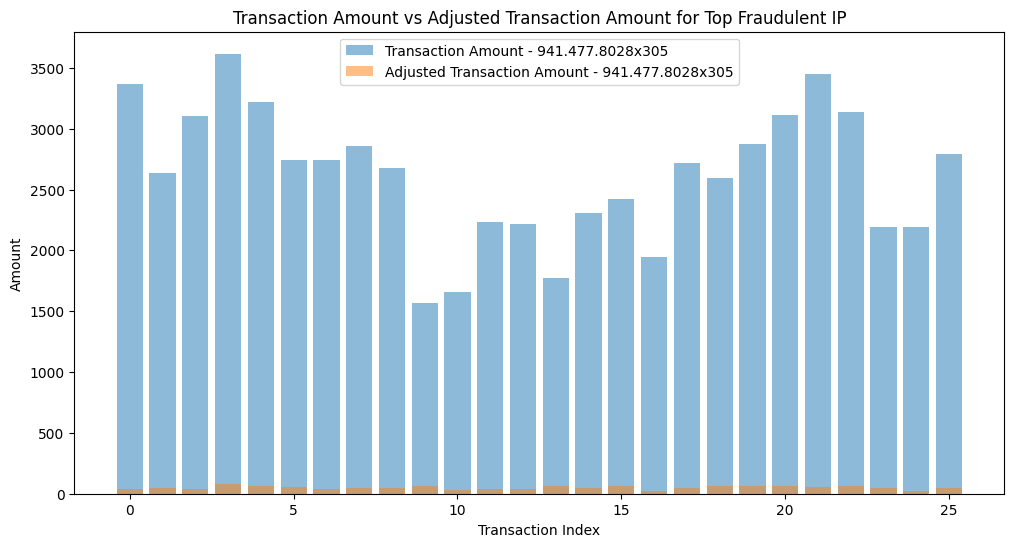

In [ ]:
top_3_fraud_ip = data[data['fraud'] == 1]['ip'].value_counts().nlargest(3).index


for ip in top_3_fraud_ip:
    plt.figure(figsize=(12, 6))
    transactions_current_ip = data[data['ip'] == ip].sort_values(by='date')
    plt.bar(range(len(transactions_current_ip)), transactions_current_ip['transaction_amt'], alpha=0.5, label=f'Transaction Amount - {ip}')
    plt.bar(range(len(transactions_current_ip)), transactions_current_ip['transaction_adj_amt'], alpha=0.5, label=f'Adjusted Transaction Amount - {ip}')
    plt.xlabel('Transaction Index')
    plt.ylabel('Amount')
    plt.title('Transaction Amount vs Adjusted Transaction Amount for Top Fraudulent IP')
    plt.legend()
    plt.show()

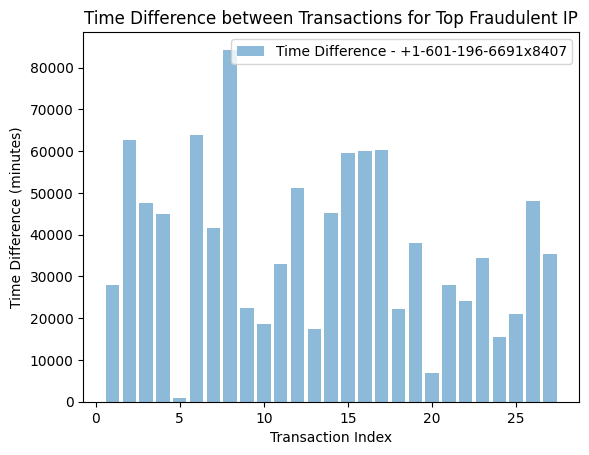

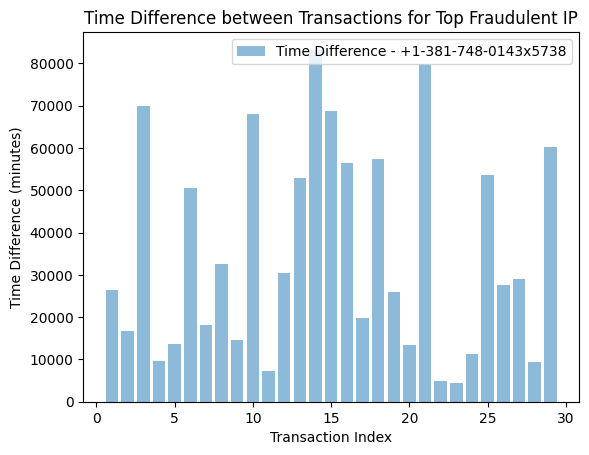

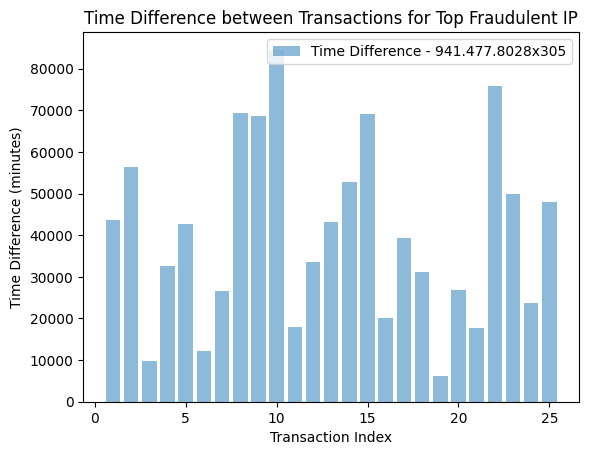

In [ ]:
top_3_fraud = data[data['fraud'] == 1]['ip'].value_counts().nlargest(3).index



for ip in top_3_fraud:
    transactions_current_ip = data[data['ip'] == ip].sort_values(by='date')

    transactions_current_ip['time_diff'] = transactions_current_ip['date'].diff().dt.seconds

    plt.bar(range(len(transactions_current_ip)), transactions_current_ip['time_diff'], alpha=0.5, label=f'Time Difference - {ip}')
    plt.xlabel('Transaction Index')
    plt.ylabel('Time Difference (minutes)')
    plt.title('Time Difference between Transactions for Top Fraudulent IP')
    plt.legend()
    plt.show()

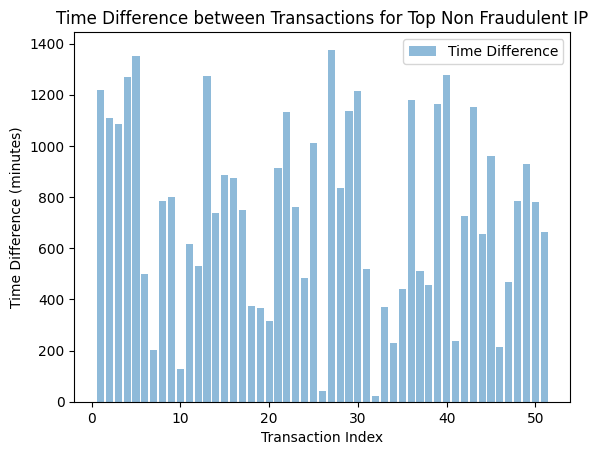

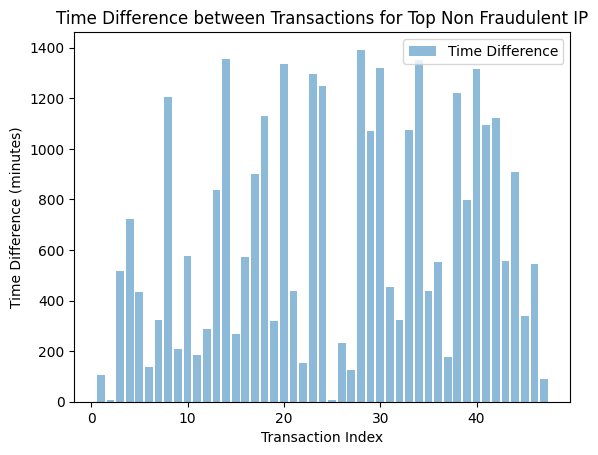

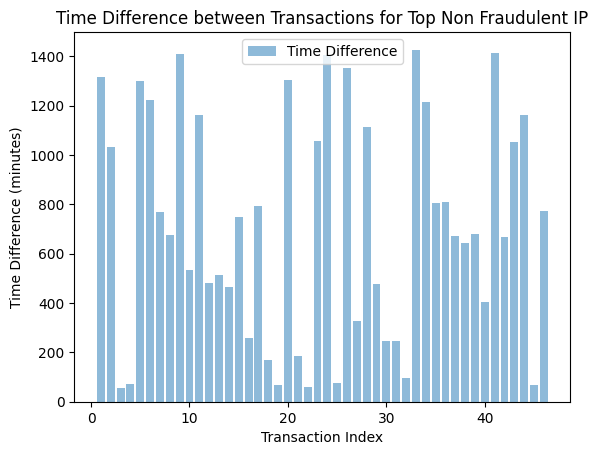

In [ ]:
top_3_fraud = data[data['fraud'] == 1]['ip'].value_counts().nlargest(3).index



for ip in top_3_fraud:
    transactions_current_ip = data[data['ip'] == ip].sort_values(by='date')

    transactions_current_ip['time_diff'] = transactions_current_ip['date'].diff().dt.seconds

    plt.bar(range(len(transactions_current_ip)), transactions_current_ip['time_diff'], alpha=0.5, label=f'Time Difference')
    plt.xlabel('Transaction Index')
    plt.ylabel('Time Difference (minutes)')
    plt.title('Time Difference between Transactions for Top Non Fraudulent IP')
    plt.legend()
    plt.show()


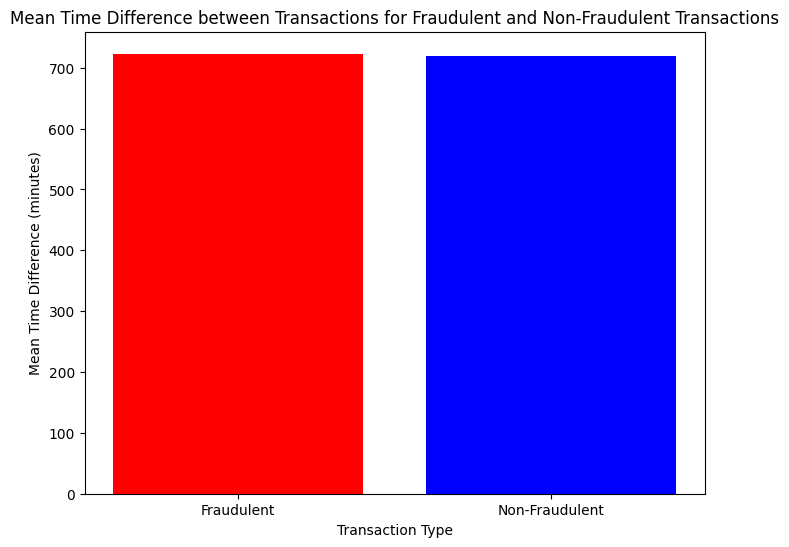

In [ ]:
fraudulent_transactions = data[data['fraud'] == 1]
non_fraudulent_transactions = data[data['fraud'] == 0]


mean_time_diff_fraudulent = fraudulent_transactions['date'].diff().dt.seconds.mean()
mean_time_diff_non_fraudulent = non_fraudulent_transactions['date'].diff().dt.seconds.mean()


plt.figure(figsize=(8, 6))
plt.bar(['Fraudulent', 'Non-Fraudulent'], [mean_time_diff_fraudulent, mean_time_diff_non_fraudulent], color=['red', 'blue'])
plt.xlabel('Transaction Type')
plt.ylabel('Mean Time Difference (minutes)')
plt.title('Mean Time Difference between Transactions for Fraudulent and Non-Fraudulent Transactions')
plt.show()


Next, I provided several more options for diagrams that could help identify dependencies in IPs on which the most fraud was detected. I was interested in **how the amount of transactions changed over time**, as well as **how much time passes between fraudulent transactions**.

Actually, I did not find any dependencies, except that ***frauder transactions can have a monthly difference in time***. And ***on average, the difference in time between fraudulent transactions and non-frauder transactions does not differ***. Anyway such an analysis can be useful. The same can be done not only for TOP popular, but also for less popular IPs/card numbers, etc., but I didn't do that in this analysis.

# It was supposed to be a good idea, but..

In [ ]:
!pip install geoip2

Next will be the part of the code that was removed. The idea was to identify a country, region and city using an IP address column. Then add separate columns that would contain information on whether the IP matches with billing country, region and city - which in a real situation would be useful information.

In [ ]:
import geoip2.database

country_reader = geoip2.database.Reader('GeoLite2-Country.mmdb')
city_reader = geoip2.database.Reader('GeoLite2-City.mmdb')


def get_country_state_city(ip):
    try:
        country_info = country_reader.country(ip)
        country_name = country_info.country.name
        city_info = city_reader.city(ip)
        state_name = city_info.subdivisions.most_specific.name
        city_name = city_info.city.name
        return country_name, state_name, city_name
    except geoip2.errors.AddressNotFoundError:
        return "Unknown", "Unknown", "Unknown"

data['country'], data['state'], data['city'] = zip(*data['ip'].apply(get_country_state_city))

In [ ]:
data.head(20)

In [ ]:
data.describe(include='O')

In [ ]:
matching_counts = data.groupby(['region', 'ip_region']).size().reset_index(name='count')

print(matching_counts.head())

There were only 2 matches for regions, so I realized that the ***IP*** data was most likely generated without a certain regularity :(

# Train Models
## Random Forest

In [ ]:
data = pd.read_csv('cleaned.csv')
data.head(2)

In [ ]:
from sklearn.model_selection import train_test_split


# Розділення на навчальний та тестувальний набори
X_train, X_test, y_train, y_test = train_test_split(data.drop('fraud', axis=1), data['fraud'], test_size=0.3, random_state=42)

class_weights = {0: 0.954, 1: 0.046}



Firstly I try Random Forest

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(class_weight=class_weights, random_state=42)

rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

In [ ]:
from sklearn import tree
import graphviz
for i in range(3):
    tr = rf_model.estimators_[i]
    dot_data = tree.export_graphviz(tr,
                               feature_names=X_train.columns,
                               filled=True,
                               max_depth=2,
                               impurity=False,
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)

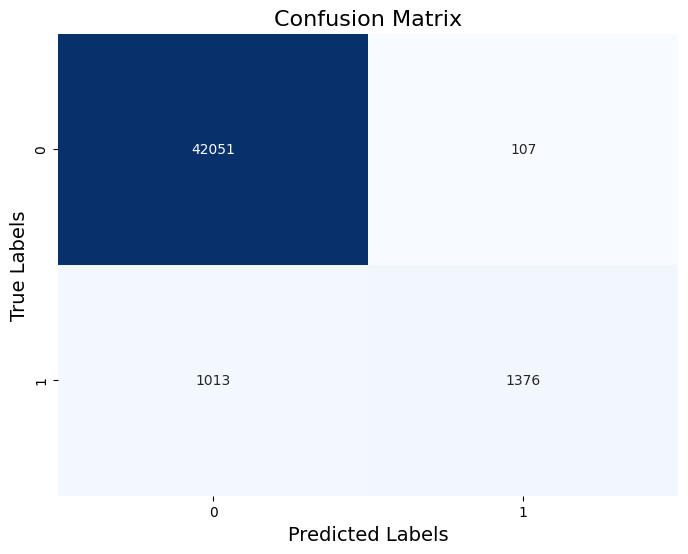

In [ ]:
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)
plt.show()

In [ ]:
# Оцінка точності моделі
train_accuracy = rf_model.score(X_train, y_train)
print("Train Accuracy:", train_accuracy)
test_accuracy = rf_model.score(X_test, y_pred_rf)
print("Test Accuracy:", test_accuracy)


precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)
print("Precision:", precision_rf)
print("Recall:", recall_rf)
print("F1-score:", f1_rf)

Train Accuracy: 0.9999807586850485
Test Accuracy: 1.0
Precision: 0.9278489548213081
Recall: 0.5759732105483466
F1-score: 0.7107438016528924


Here it is worth noting that the ***Accuracy*** measure is not suitable for us to evaluate the model, since the data is not balanced. The evaluation should be carried out according to the confusion matrix and measures that include both classes - ***recall*** and ***F1-score***.

But ***Recall*** is less than 60% - and considering other indicators, the model has probably overfitted. This may be due to imbalanced data and suboptimally selected hyperparameters of the model. Therefore, I decided to try ***Gradient Boosting*** - it copes better with imbalance.

## Gradient Boosting

This is the final version of the model - the parameters have already been selected here. As you can see, the accuracy of Gradient Boosting is indeed higher, but we had to experiment with the parameters, because some overtrained the model, and some undertrained.

Recall: 0.7031551835157759
F1 Score: 0.7915911562160203
Confusion Matrix:
 [[28031   114]
 [  461  1092]]


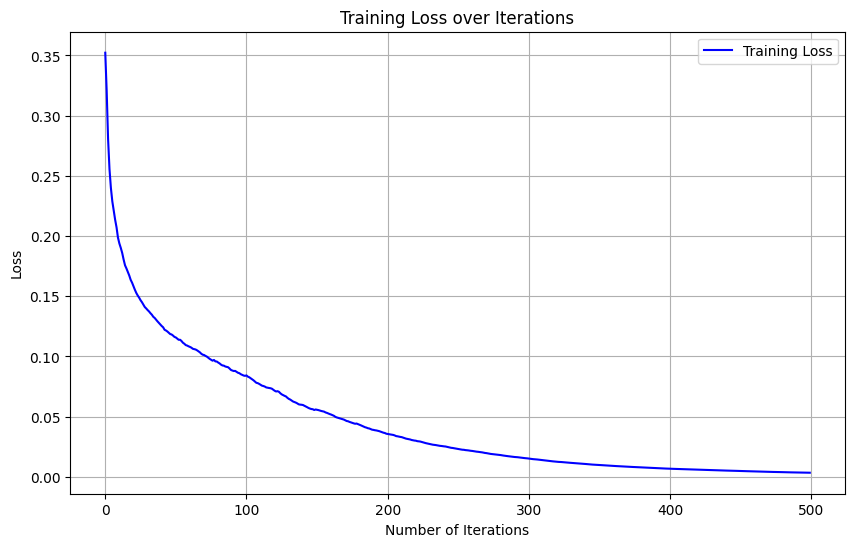

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(data.drop('fraud', axis=1), data['fraud'], test_size=0.2, random_state=42)

gb_classifier = GradientBoostingClassifier(n_estimators=500, learning_rate=0.2, max_depth=7, max_features='log2', min_samples_leaf=4,
                           min_samples_split=10)


gb_classifier.fit(X_train, y_train)
y_pred = gb_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_matrix)


#feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': gb_classifier.feature_importances_})
#feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
#print(feature_importance_df)


loss_history = gb_classifier.train_score_

plt.figure(figsize=(10, 6))
plt.plot(loss_history, label='Training Loss', color='blue')
plt.xlabel('Number of Iterations')
plt.ylabel('Loss')
plt.title('Training Loss over Iterations')
plt.legend()
plt.grid(True)
plt.show()


At this point I also decided to check `feature_importance_df`. It showed similar to the correlation matrix so I won't detain your attention on that.

Also, I monitored the ***Training Loss*** throughout the model training - this allowed me to understand if the model was overfitting, in case the ***Training Loss*** suddenly increased.

In [ ]:
from joblib import dump

filename = 'final_model.joblib'

# save model
dump(gb_classifier, filename)

['final_model.joblib']

In [ ]:
from joblib import load
loaded_model = load(filename)
y_pred = gb_classifier.predict(X_test)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_matrix)

Recall: 0.7057308435286542
F1 Score: 0.7962223029422448
Confusion Matrix:
 [[28041   104]
 [  457  1096]]


# Selection of hyperparameters for the ***Gradient Boosting*** model

In [ ]:
from sklearn.model_selection import GridSearchCV

gb_classifier = GradientBoostingClassifier(learning_rate=0.3, random_state=42)

param_grid = {
    'max_depth': [3, 5, 7]
}

grid_search = GridSearchCV(estimator=gb_classifier, param_grid=param_grid, cv=5, scoring='recall', verbose=1)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best Parameters: {'max_depth': 7}


I was looking for the max_depth parameter using this method. Greater depth means better accuracy. But you have to be careful about overfitting.

Learning Rate: 0.01, Train Recall: 0.21517434729279833
Learning Rate: 0.05, Train Recall: 0.5077974417382162
Learning Rate: 0.1, Train Recall: 0.587524093218854
Learning Rate: 0.2, Train Recall: 0.6565621166987909
Learning Rate: 0.3, Train Recall: 0.6914315752584546
Learning Rate: 0.01, Last Training Loss: 0.281987732191511
Learning Rate: 0.05, Last Training Loss: 0.20550452714862089
Learning Rate: 0.1, Last Training Loss: 0.17602791886642477
Learning Rate: 0.2, Last Training Loss: 0.15179640306785253
Learning Rate: 0.3, Last Training Loss: 0.14233251123173948


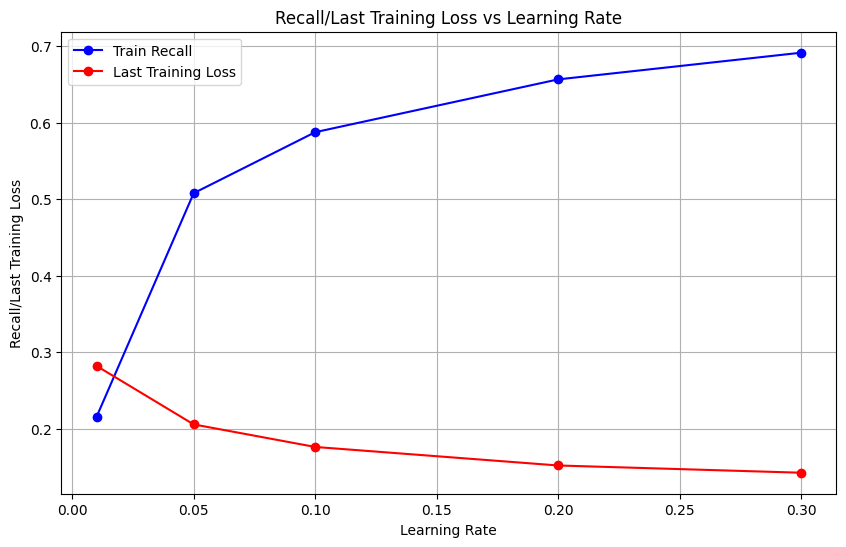

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score

learning_rates = [0.01, 0.05, 0.1, 0.2, 0.3]

train_recalls = {}
train_losses = {}

for lr in learning_rates:
    gb_classifier = GradientBoostingClassifier(learning_rate=lr, random_state=42)
    gb_classifier.fit(X_train, y_train)

    train_recall = recall_score(y_train, gb_classifier.predict(X_train))

    train_losses[lr] = gb_classifier.train_score_[-1]

    train_recalls[lr] = train_recall

for lr, train_recall in train_recalls.items():
    print(f"Learning Rate: {lr}, Train Recall: {train_recall}")

for lr, train_loss in train_losses.items():
    print(f"Learning Rate: {lr}, Last Training Loss: {train_loss}")



plt.figure(figsize=(10, 6))
plt.plot(train_recalls.keys(), train_recalls.values(), marker='o', label='Train Recall', color='blue')
plt.plot(train_losses.keys(), train_losses.values(), marker='o', label='Last Training Loss', color='red')
plt.xlabel('Learning Rate')
plt.ylabel('Recall/Last Training Loss')
plt.title('Recall/Last Training Loss vs Learning Rate')
plt.legend()
plt.grid(True)
plt.show()


A small value of learning rate usually helps to avoid overfitting. The algorithm offers us Learning Rate=0.3, but with this value the model sometimes was retrained, so in the final version I took Learning Rate=0.2

In [ ]:
from sklearn.model_selection import GridSearchCV
rf_clf = GradientBoostingClassifier()

# Створення сітки параметрів для пошуку
param_grid = {
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Створення об'єкта GridSearchCV
grid_search = GridSearchCV(estimator=rf_clf, param_grid=param_grid, cv=5, scoring='recall')

# Запуск пошуку по сітці параметрів
grid_search.fit(X_train, y_train)

# Отримання кращих параметрів
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Отримання кращої моделі
best_model = grid_search.best_estimator_
print("Best Model:", best_model)

Best Parameters: {'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5}
Best Model: GradientBoostingClassifier(max_features='sqrt', min_samples_split=5)


Finding the remaining parameters- min_samples_split, min_samples_leaf, max_features.

# **Summary:**

The model is good at detecting fraud, but there is a risk of misclassifying incorrect transactions as fraudulent. (out of 30,000 NON-fraudulent observations, ~450 may be falsely identified as fraudulent)